# Libraries

In [ ]:
!pip install transformers

     |████████████████████████████████| 1.3MB 9.7MB/s 
     |████████████████████████████████| 2.9MB 47.3MB/s 
     |████████████████████████████████| 1.1MB 41.9MB/s 
     |████████████████████████████████| 890kB 49.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=b95d34107f7918d25cd929d3bc31ab7cb1e05b4a40311c7734c7cdb9fba3eef3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
# import warnings
# warnings.filterwarnings('ignore')

# Dataset
import os
from google.colab import drive  
from sklearn.utils import class_weight

# general
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torchtext
import torch

# Preliminaries
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Models
import torch.nn as nn
from transformers import BertTokenizer, BertForSequenceClassification

# Training
import torch.optim as optim

# Evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

Using Google Colab files

In [ ]:
drive.mount(r'/content/drive/',force_remount=True) 

filename = 'accidental_sessions_data.parquet'
data_dir = os.getcwd() + '/' + 'drive/My Drive/Colab Notebooks/NLP/Project/data/'
data_dir

Mounted at /content/drive/


'/content/drive/My Drive/Colab Notebooks/NLP/Project/data/'

# Dataset

## Read Dataset

In [ ]:
df = pd.read_parquet(data_dir + filename)

print('Number of training sentences: {:,}\n'.format(df.shape[0]))

df.head()

Number of training sentences: 41,890



,message,label
0,"not sure, still in progress",1
1,Yes,1
2,How can I increase my mbps,1
3,I have had to call every single month to take ...,0
4,Hi! Can you help me get started with my new ph...,0


## Class Weights

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(df.label),df.label)
class_weights[1] = class_weights[1]*5
class_weights

array([ 0.52363809, 55.38075093])

# Preliminaries

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
# Model parameter
MAX_SEQ_LEN = 32
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)

# Fields
id_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, tokenize=tokenizer.encode, lower=False, include_lengths=False, batch_first=True,
                   fix_length=MAX_SEQ_LEN, pad_token=PAD_INDEX, unk_token=UNK_INDEX)
fields = [('id',id_field), ('message', text_field),('label', label_field),]

# TabularDataset
train, valid, test = TabularDataset.splits(path=data_dir, train='train.csv', validation='valid.csv',test='test.csv', format='CSV', fields=fields, skip_header=True)

# Iterators
train_iter = BucketIterator(train, batch_size=16, sort_key=lambda x: len(x.message),
                            device=device, train=True, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=16, sort_key=lambda x: len(x.message),
                            device=device, train=True, sort=True, sort_within_batch=True)
test_iter = Iterator(test, batch_size=16, device=device, train=False, shuffle=False, sort=False)

Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors


# Model

In [ ]:
class BERT(nn.Module):

    def __init__(self,freeze=False,freeze_embeddings=False):
        super(BERT, self).__init__()

        options_name = "bert-base-uncased"
        self.encoder = BertForSequenceClassification.from_pretrained(options_name)

        if freeze_embeddings:
          for param in list(self.encoder.bert.embeddings.parameters()):
            param.requires_grad = False

        if freeze:
          for param in list(self.encoder.bert.parameters()):
            param.requires_grad = False
          

    def forward(self, text, label):
        loss, text_fea = self.encoder(text, labels=label)[:2]

        return loss, text_fea

# Training

### Save and Load Functions

In [ ]:
def save_checkpoint(save_path, model, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')

def load_checkpoint(load_path, model):
    
    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

### Training Function

In [ ]:
def train(model,
          optimizer,
          criterion = nn.BCELoss(weight=torch.Tensor(class_weights)),
          train_loader = train_iter,
          valid_loader = valid_iter,
          num_epochs = 10,
          eval_every = len(train_iter) // 2,
          best_valid_loss = float("Inf")):
    
    print('initialize running values')
    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []

    print('training loop')
    # training loop
    
    for epoch in range(num_epochs):
        for (id_,titletext,labels), _ in train_loader:
            model.train()
            # print('labels',labels.shape)
            # print('titletext',titletext.shape)
            labels = labels.type(torch.LongTensor)           
            labels = labels.to(device)
            titletext = titletext.type(torch.LongTensor)  
            titletext = titletext.to(device)
            output = model(titletext, labels)
            loss, _ = output

            # print('got loss',loss)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    

                    # validation loop
                    for (id_,titletext,labels), _ in valid_loader:
                        labels = labels.type(torch.LongTensor)           
                        labels = labels.to(device)
                        titletext = titletext.type(torch.LongTensor)  
                        titletext = titletext.to(device)
                        output = model(titletext, labels)
                        loss, _ = output
                        
                        valid_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_valid_loss = valid_running_loss / len(valid_loader)
                train_loss_list.append(average_train_loss)
                valid_loss_list.append(average_valid_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_valid_loss))
                
                # checkpoint
                if best_valid_loss > average_valid_loss:
                    best_valid_loss = average_valid_loss
                    save_checkpoint(data_dir + 'model.pt', model, best_valid_loss)
                    save_metrics(data_dir  + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    
    save_metrics(data_dir  + 'metrics.pt', train_loss_list, valid_loss_list, global_steps_list)
    print('Finished Training!')

### Train The Model

In [ ]:
model = BERT().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)


print(model._modules['encoder']._modules['classifier'].weight)

train(model=model, optimizer=optimizer)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Parameter containing:
tensor([[-0.0124,  0.0109,  0.0021,  ..., -0.0148,  0.0228, -0.0295],
        [ 0.0243,  0.0073,  0.0066,  ...,  0.0077,  0.0023, -0.0192]],
       device='cuda:0', requires_grad=True)
initialize running values
training loop
Epoch [1/10], Step [785/15710], Train Loss: 0.1822, Valid Loss: 0.1086
Model saved to ==> /content/drive/My Drive/Colab Notebooks/NLP/Project/data/model.pt
Model saved to ==> /content/drive/My Drive/Colab Notebooks/NLP/Project/data/metrics.pt
Epoch [1/10], Step [1570/15710], Train Loss: 0.0438, Valid Loss: 0.1125
Epoch [2/10], Step [2355/15710], Train Loss: 0.1354, Valid Loss: 0.0924
Model saved to ==> /content/drive/My Drive/Colab Notebooks/NLP/Project/data/model.pt
Model saved to ==> /content/drive/My Drive/Colab Notebooks/NLP/Project/data/metrics.pt
Epoch [2/10], Step [3140/15710], Train Loss: 0.0317, Valid Loss: 0.0981
Epoch [3/10], Step [3925/15710], Train Loss: 0.1153, Valid Loss: 0.0978
Epoch [3/10], Step [4710/15710], Train Loss: 0.022

### Loss - Train, Valid  

Model loaded from <== /content/drive/My Drive/Colab Notebooks/NLP/Project/data//metrics.pt


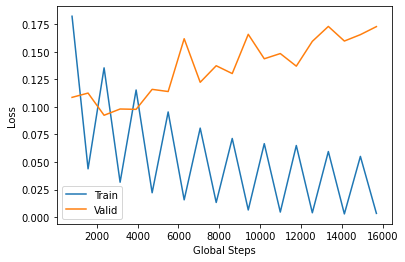

In [ ]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics(data_dir + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show();

# Evaluation

### Evaluation Function

In [ ]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (id_, titletext, labels), _ in test_loader:

                labels = labels.type(torch.LongTensor)           
                labels = labels.to(device)
                titletext = titletext.type(torch.LongTensor)  
                titletext = titletext.to(device)
                output = model(titletext, labels)

                _, output = output
                y_pred.extend(torch.argmax(output, 1).tolist())
                y_true.extend(labels.tolist())
    
    print('\n\nClassification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['mistake', 'REAL'])
    ax.yaxis.set_ticklabels(['mistake', 'REAL'])

### Evaluating Model

##### Current Model




Classification Report:
              precision    recall  f1-score   support

           1     0.5569    0.6479    0.5990       355
           0     0.9843    0.9772    0.9807      8023

    accuracy                         0.9632      8378
   macro avg     0.7706    0.8125    0.7898      8378
weighted avg     0.9662    0.9632    0.9646      8378



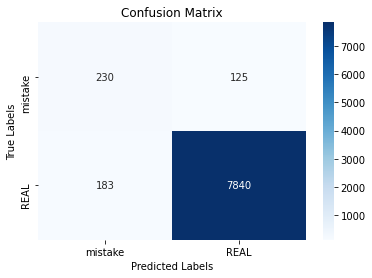

In [ ]:
evaluate(model, test_iter)

##### Best Model (based on loss)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/drive/My Drive/Colab Notebooks/NLP/Project/data/model.pt


Classification Report:
              precision    recall  f1-score   support

           1     0.6743    0.4141    0.5131       355
           0     0.9745    0.9912    0.9828      8023

    accuracy                         0.9667      8378
   macro avg     0.8244    0.7026    0.7479      8378
weighted avg     0.9618    0.9667    0.9629      8378



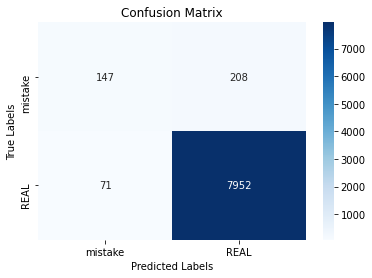

In [ ]:
best_model = BERT(freeze=True).to(device)

load_checkpoint(data_dir + 'model.pt', best_model)

evaluate(best_model, test_iter)

##### Output Example



In [ ]:
model = BERT(freeze=True).to(device)
load_checkpoint(data_dir + 'model.pt', best_model)

y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for (id_, text_, labels_), _ in test_iter:

      labels_ = labels_.type(torch.LongTensor)           
      labels_ = labels_.to(device)
      
      text_ = text_.type(torch.LongTensor)  
      text_ = text_.to(device)
      output = model(text_, labels_)

      _, output = output
      y_pred.extend(torch.argmax(output, 1).tolist())
      y_true.extend(labels_.tolist())
      break

pd.options.display.max_colwidth = 100
l = [{'Sentence':tokenizer.decode(s[s.nonzero()]),'Label':l,'Prediction':p} for s,l,p in zip(text_,y_true,y_pred)]
sentences = pd.DataFrame(l,columns=['Sentence','Label','Prediction'])
sentences.sample(5)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded from <== /content/drive/My Drive/Colab Notebooks/NLP/Project/data/model.pt


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)


,Sentence,Label,Prediction
13,[CLS] hello is there a way i can add more hotspot gb? [SEP],0,0
3,[CLS] my screen cracked and i was wondering how much it would cost to get it fixed [SEP],0,0
8,"[CLS] hello, i am reaching out to remove sprint complete from my account. [SEP]",0,0
1,[CLS] needing a cracked screen repaired. [SEP],0,0
11,[CLS] why isn't my camera working? [SEP],0,0


<br><br><br>
<br><br><br>
<br><br><br>

# Final Decision

I need to choose the right model based on a business decission.
Also, I can see that the current model strats to overfit.